In [27]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import t
%matplotlib inline


sns.set(rc={'figure.figsize':(6,3)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('axes', unicode_minus=False)

#results_dir = "../evalScripts/webshop/manualOptimizerConstantLoad/statistics/highload-bursty_workload-3"
#results_dir = "../evalScripts/webshop/generateConfigurations/statistics/everything-m-15-x-60-x-3"
#results_dir = "../evalScripts/split/generateConfigurations/statistics/testcpu88moremem-A-8-x-15-x-10"
results_dir = "../evalScripts/split/generateConfigurations/statistics/dualcore-A-13-x-100-x-10"

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

def get_df_grouped(results_dir):
    results_dir = "../../" + results_dir
    json_files = [pos_json for pos_json in os.listdir(results_dir) if "json" in pos_json and "configuration" not in pos_json]

    data = []
    for index, json_fn in enumerate(json_files):
        with open(os.path.join(results_dir, json_fn)) as in_file:
            fusion_group = json_fn.removesuffix('.json')
            content = json.load(in_file)
            #print(f'Read fusion group {fusion_group} with {len(content)} lines')
            data.extend(content)
    configuration_metadata = []
    with open(os.path.join(results_dir, "configuration/configurationMetadata.json")) as in_file:
        configuration_metadata = pd.DataFrame.from_dict(json.load(in_file))

    df = pd.DataFrame.from_dict(data)
    df["memoryAvail"] = pd.to_numeric(df["memoryAvail"])

    # Get the smallest Start timestamp and remove it from every timestamp value
    min_start_timestamp = df["startTimestamp"].min()
    df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
    df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
    df["duration"] =  df["endTimestamp"] - df["startTimestamp"]
    df["totalCost"] = 0.0000166667 * 0.000001 * df["memoryAvail"].astype(float) * df["billedDuration"].astype(float)

    # Now do not count every invocation, but sort the df by the cost of trace
    grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min', 'totalCost': 'sum', 'memoryAvail': ['min']})
    #grouped['numInvocations'] = df.groupby('traceId').count()
    grouped['numInvocations'] = df.groupby('traceId').size()
    #print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

    # Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
    # Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
    rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
    grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
    grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]
    fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])

    return (df, grouped, fusion_groups_order)

def calculate_handler_overhead(df, name = ""):
    # df = df[df["actualInternalDuration"] >= 0]
    oh = df["duration"] - df["actualInternalDuration"]
    warm = oh[oh <= 10]#oh[df["isColdStart"] == False]
    cold = oh[oh > 10]#oh[df["isColdStart"] == True]
    print(f'{name}: mean: {oh.mean()} median: {oh.median()} stdev: {oh.std()} 25perc: {oh.quantile(0.25)} 75perc: {oh.quantile(0.75)} 90perc: {oh.quantile(0.90)} 99perc: {oh.quantile(0.99)} max:{oh.max()} len: {len(oh)} coldMean: {cold.mean()} coldStd: {cold.std()} warmMean: {warm.mean()} warmStd: {warm.std()}\n')
    sns.ecdfplot(data=df, x=df["duration"] - df["actualInternalDuration"])
    plt.show()

def prepare_diff_memory_cost(df, function_name, fixForSize = False, fixForSizeGroup = ""):
    invocations = df.loc[df["currentTask"] == function_name]
    if fixForSize:
        #invocations = invocations.query("fusionGroup == @fixForSizeGroup | memoryAvail != @fixForSizeSize")
        invocations["fusionGroup"] = pd.to_numeric(invocations["fusionGroup"])
        invocations = invocations.query("fusionGroup >= @fixForSizeGroup")
    #sizes = invocations["memoryAvail"].unique()
    return invocations
    # sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))
    # plt.title(f"Total Cost for function {function_name}")
    # plt.xlabel("total cost [$]")
    # plt.show()
    # sns.lineplot(data=invocations, x="memoryAvail", y="totalCost")
    # plt.title(f"Cost depending on memory, function that uses two threads {function_name}")
    # plt.xlabel("memory available [MB]")
    # plt.show()
    # sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))
    # plt.title(f"Cost depending on memory, function that uses two threads {function_name}")
    # plt.xlabel("memory available [MB]")
    # plt.show()

def printStats(grouped, fusion_groups_order):
    def printMeanAndCi(x, name=""):
        m = x.mean() 
        s = x.std() 
        dof = len(grouped)-1 
        confidence = 0.95

        t_crit = np.abs(t.ppf((1-confidence)/2,dof))
        print(f'Mean: {m}, Confidence Interval: ({m-s*t_crit/np.sqrt(len(x))} / {m+s*t_crit/np.sqrt(len(x))}), Median: {x.median()} for {name}')

    print("------ overall")
    printMeanAndCi(grouped["rootDuration"], "rootDuration")
    printMeanAndCi(grouped['billedDuration', 'sum'], "billedDuration")
    printMeanAndCi(grouped['totalCost', 'sum'], f'totalCost')
    for group in fusion_groups_order:
        filtered = grouped[grouped['fusionGroup', 'min'] == group]
        print("------ " + str(group))
        print(" minmem:", filtered['memoryAvail', 'min'].unique())
        printMeanAndCi(filtered["rootDuration"], f'rootDuration')
        printMeanAndCi(filtered['billedDuration', 'sum'], f'billedDuration')
        printMeanAndCi(filtered['totalCost', 'sum'], f'totalCost')

cmap = sns.color_palette("bright", as_cmap=True)

# Split Normal

In [28]:

tree0 = cmap[0]
tree1 = cmap[6]
tree2 = cmap[2]
tree3 = cmap[3]
tree3o = cmap[4]
treel = cmap[1]

colors = [tree0, tree1, tree2, tree3, tree3o]

In [29]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/generateConfigurations/statistics/dualcore-A-13-x-100-x-10")

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


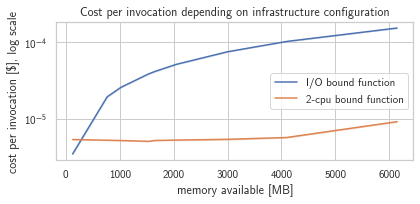

In [30]:
# plot total cost depending on memory size for a figure in the beginning of the paper
invA = prepare_diff_memory_cost(df, "A", False, 1675346654)
invG = prepare_diff_memory_cost(df, "G", False, 1675346654)

sns.lineplot(data=invA, x="memoryAvail", y="totalCost", label="I/O bound function")
sns.lineplot(data=invG, x="memoryAvail", y="totalCost", label="2-cpu bound function")
plt.title(f"Cost per invocation depending on infrastructure configuration")
plt.xlabel("memory available [MB]")
plt.ylabel("cost per invocation [$], log scale")
plt.yscale("log")
ax = plt.gca()
save_fig(ax, "compareIOBoundCPUBound")
plt.show()

In [31]:
# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "1675344670": "Tree$_0$",
    "1675345536": "Tree$_1$",
    "1675346078": "Tree$_2$",
    "1675346654": "Tree$_3$", # (128MB)
    "1675347190": "Tree$_3$ (768MB)",
    "1675347701": "Tree$_3$ (1024MB)",
    "1675348211": "Tree$_3$ (1536MB)",
    "1675348735": "Tree$_3$ (1650MB)",
    "1675349244": "Tree$_3$ (2048MB)",
    "1675349754": "Tree$_3$ (3000MB)",
    "1675350261": "Tree$_3$ (4096MB)",
    "1675350785": "Tree$_3$ (6144MB)",
    "1675351296": "Tree$_3$ (opt)",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

# Only show the initial 3 and optimal fusion group
cond = (grouped['fusionGroup', 'min'] < 1675347190) | (grouped['fusionGroup', 'min'] == 1675351296)
grouped_filtered = grouped[cond]

cond = (df['fusionGroup'] < 1675347190) | (df['fusionGroup'] == 1675351296)
df_filtered = df[cond]


TeX  NOT subset; don't know how to subset; dropped


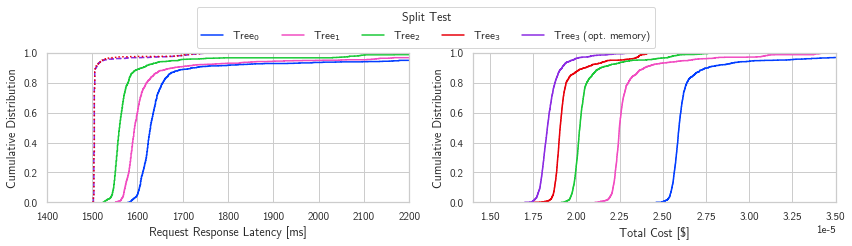

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)

ax1.lines[0].set_linestyle("--")
ax1.lines[1].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=["Tree$_0$", "Tree$_1$", "Tree$_2$", "Tree$_3$", "Tree$_3$ (opt. memory)"], ncol=5, loc="upper center", title="Split Test", bbox_to_anchor=(0, 0.66, 1, 0.5))
save_fig(fig, "split/allNormal")

In [33]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 1545.0899584807012, Confidence Interval: (1541.8135624731028 / 1548.3663544882995), Median: 1505.0 for rootDuration
Mean: 4687.344610179917, Confidence Interval: (4618.713832589083 / 4755.975387770752), Median: 2201.0 for billedDuration
Mean: 5.8163094776928254e-05, Confidence Interval: (5.7369698534801534e-05 / 5.8956491019054974e-05), Median: 4.09942153216e-05 for totalCost
------ 1675344670
 minmem: [128]
Mean: 1755.861, Confidence Interval: (1723.6964776522382 / 1788.025522347762), Median: 1629.0 for rootDuration
Mean: 12529.3, Confidence Interval: (12441.927854487594 / 12616.672145512404), Median: 12158.0 for billedDuration
Mean: 2.672922679168e-05, Confidence Interval: (2.6542832508465716e-05 / 2.6915621074894285e-05), Median: 2.59371185408e-05 for totalCost
------ 1675345536
 minmem: [128]
Mean: 1669.09, Confidence Interval: (1649.4913326678823 / 1688.6886673321176), Median: 1594.0 for rootDuration
Mean: 10793.154, Confidence Interval: (10737.89015640799 / 1

# Split Cold Starts

In [34]:
colors = [tree0, tree3, tree3o, treel]

In [35]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/coldStarts/statistics/dualcore-4")
new_fs_names = {
    "a_remote": "Tree$_0$",
    "d_optimal_small": "Tree$_3$", # (128MB)
    "c_optimal": "Tree$_3$ (opt)",
    "b_local": "all local" # Maybe comment this out...
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


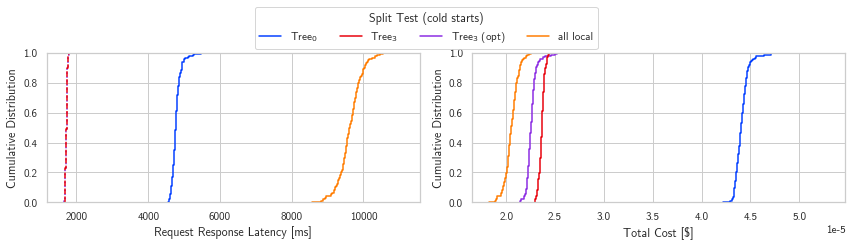

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ['Tree$_0$', 'Tree$_3$', 'Tree$_3$ (opt)', "all local"]
sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

ax1.lines[2].set_linestyle("--")
ax1.lines[1].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, ncol=5, loc="upper center", title="Split Test (cold starts)", bbox_to_anchor=(0, 0.66, 1, 0.5))
save_fig(fig, "split/allCold")


In [37]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 4464.635, Confidence Interval: (4239.519921116199 / 4689.7500788838015), Median: 3178.0 for rootDuration
Mean: 11001.33125, Confidence Interval: (10552.979761036922 / 11449.682738963076), Median: 10742.5 for billedDuration
Mean: 2.7735743471376e-05, Confidence Interval: (2.707175795092897e-05 / 2.839972899182303e-05), Median: 2.3205379744e-05 for totalCost
------ a_remote
 minmem: [128]
Mean: 4790.195, Confidence Interval: (4763.415223128763 / 4816.974776871237), Median: 4762.5 for rootDuration
Mean: 20692.375, Confidence Interval: (20634.00028443287 / 20750.74971556713), Median: 20644.0 for billedDuration
Mean: 4.41438216208e-05, Confidence Interval: (4.401928864519134e-05 / 4.426835459640866e-05), Median: 4.4040621414400004e-05 for totalCost
------ b_local
 minmem: [128]
Mean: 9631.275, Confidence Interval: (9584.398984886651 / 9678.151015113348), Median: 9620.0 for rootDuration
Mean: 9634.345, Confidence Interval: (9587.39505931628 / 9681.294940683718), Median: 

# Split Bursty Workload

In [38]:
# Bursty Workload
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/manualOptimizerConstantLoad/statistics/bursty_workload-4")
new_fs_names = {
    "a_remote": "Tree$_0$",
    "d_optimal_small": "Tree$_3$", # (128MB)
    "c_optimal": "Tree$_3$ (opt)",
    "b_local": "all local" # Maybe comment this out...
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


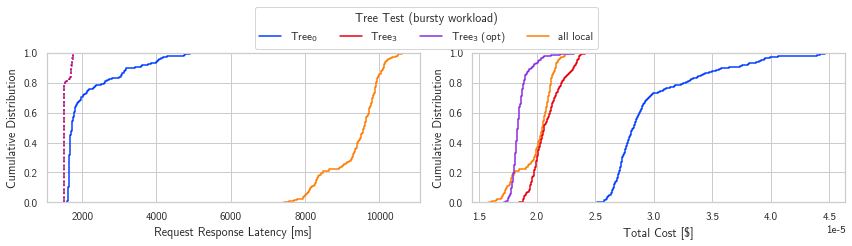

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ['Tree$_0$', 'Tree$_3$', 'Tree$_3$ (opt)',"all local"]

sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

ax1.lines[1].set_linestyle("--")
ax1.lines[2].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, ncol=5, loc="upper center", title="Tree Test (bursty workload)", bbox_to_anchor=(0, 0.66, 1, 0.5))
save_fig(fig, "split/bursty")

In [40]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 3184.063400576369, Confidence Interval: (3023.6487918964876 / 3344.4780092562505), Median: 1648.0 for rootDuration
Mean: 8809.773775216137, Confidence Interval: (8571.706684574412 / 9047.840865857863), Median: 9633.0 for billedDuration
Mean: 2.2509799486367724e-05, Confidence Interval: (2.223927957910562e-05 / 2.278031939362983e-05), Median: 2.05803078272e-05 for totalCost
------ a_remote
 minmem: [128]
Mean: 2122.976, Confidence Interval: (2042.3457461577566 / 2203.606253842244), Median: 1720.0 for rootDuration
Mean: 13982.872, Confidence Interval: (13785.457934182963 / 14180.286065817036), Median: 13246.0 for billedDuration
Mean: 2.9830186593587208e-05, Confidence Interval: (2.9409035744210847e-05 / 3.0251337442963568e-05), Median: 2.82581898496e-05 for totalCost
------ b_local
 minmem: [128]
Mean: 9369.285171102661, Confidence Interval: (9282.61049312722 / 9455.959849078103), Median: 9581.0 for rootDuration
Mean: 9373.866920152092, Confidence Interval: (9287.416

# IoT Normal

In [41]:
cmap = sns.color_palette("bright", 9, as_cmap=True)
iot0 = cmap[0]
iot1 = cmap[6]
iot2 = cmap[2]
iot3 = cmap[3]
iot4 = cmap[4]
iot5 = cmap[1]
iot5o = cmap[9]
iotl = cmap[8]

In [42]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/IoT/generateConfigurations/statistics/dualcore-I-100x10x11")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "1676018871": "IoT$_0$",
    "1676019806": "IoT$_1$",
    "1676020374": "IoT$_2$",
    "1676020922": "IoT$_3$",
    "1676021466": "IoT$_4$",
    "1676021998": "IoT$_5$", # (128MB)
    "1676022528": "IoT$_5$ (768 MB)",
    "1676023227": "IoT$_5$ (1024 MB)",
    "1676024794": "IoT$_5$ (1536 MB)",
    "1676025759": "IoT$_5$ (1650 MB)",
    "1676026378": "IoT$_5$ (2048 MB)",
    "1676026914": "IoT$_5$ (opt)",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

# Only show the initial 3 and optimal fusion group
cond = (grouped['fusionGroup', 'min'] <= 1676021998) | (grouped['fusionGroup', 'min'] == 1676026914)
grouped_filtered = grouped[cond]

cond = (df['fusionGroup'] <= 1675347190) | (df['fusionGroup'] == 1675351296)
df_filtered = df[cond]

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


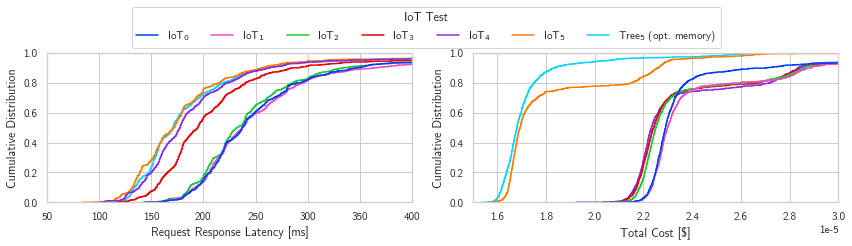

In [43]:
colors = [iot0, iot1, iot2, iot3, iot4, iot5, iot5o]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.set_xlim(50, 400)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
ax2.set_xlim(0.000015, 0.00003)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)

#ax1.lines[0].set_linestyle("--")
#ax1.lines[1].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=["IoT$_0$", "IoT$_1$", "IoT$_2$", "IoT$_3$", "IoT$_4$", "IoT$_5$", "Tree$_5$ (opt. memory)"], ncol=7, loc="upper center", title="IoT Test", bbox_to_anchor=(0, 0.66, 1, 0.5))
save_fig(fig, "iot/allNormal")

In [44]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 172.51503289747646, Confidence Interval: (168.95400672967156 / 176.07605906528136), Median: 157.0 for rootDuration
Mean: 6335.885067044224, Confidence Interval: (6246.609328259519 / 6425.160805828929), Median: 7651.0 for billedDuration
Mean: 2.138879448345272e-05, Confidence Interval: (2.1315245158150072e-05 / 2.1462343808755366e-05), Median: 2.1615043230000003e-05 for totalCost
------ 1676018871
 minmem: [128]
Mean: 298.806, Confidence Interval: (280.6727940550899 / 316.93920594491004), Median: 237.0 for rootDuration
Mean: 11389.649, Confidence Interval: (11257.863078335855 / 11521.434921664144), Median: 10738.5 for billedDuration
Mean: 2.4297966462502402e-05, Confidence Interval: (2.401682260066563e-05 / 2.4579110324339175e-05), Median: 2.2908845817600002e-05 for totalCost
------ 1676019806
 minmem: [128]
Mean: 301.8061938061938, Confidence Interval: (283.57498737681817 / 320.0374002355694), Median: 237.0 for rootDuration
Mean: 11631.773226773226, Confidence Inte

# IoT Coldstarts

In [45]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/IoT/coldStarts/statistics/dualcore")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "a_remote": "IoT$_0$",
    "b_local": "all local",
    "c_optimal_small": "IoT$_5$",
    "c_optimal": "IoT$_5$ (opt)",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


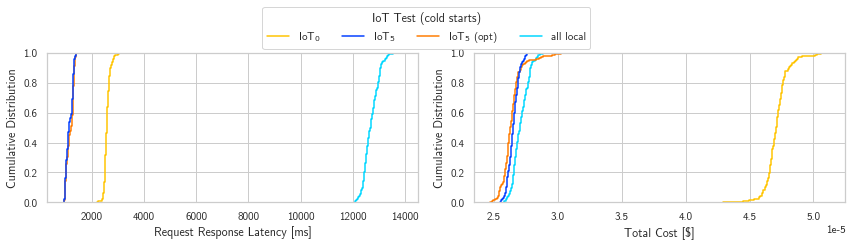

In [46]:
colors = [iotl, iot0, iot5, iot5o]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ['IoT$_0$', 'IoT$_5$', 'IoT$_5$ (opt)',"all local"]
sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)


fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, ncol=5, loc="upper center", title="IoT Test (cold starts)", bbox_to_anchor=(0, 0.66, 1, 0.5))
save_fig(fig, "iot/allCold")

In [47]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 4404.50125, Confidence Interval: (4068.928145696645 / 4740.074354303355), Median: 1812.5 for rootDuration
Mean: 14236.17375, Confidence Interval: (13910.005205197896 / 14562.342294802103), Median: 12530.5 for billedDuration
Mean: 3.180235739625425e-05, Confidence Interval: (3.1185285664862046e-05 / 3.241942912764646e-05), Median: 2.68576537152e-05 for totalCost
------ a_remote
 minmem: [128]
Mean: 2590.475, Confidence Interval: (2573.311108845795 / 2607.638891154205), Median: 2574.5 for rootDuration
Mean: 22094.015, Confidence Interval: (22034.687677554277 / 22153.342322445722), Median: 22079.0 for billedDuration
Mean: 4.7133992934464e-05, Confidence Interval: (4.700742772678321e-05 / 4.7260558142144784e-05), Median: 4.7101960870400006e-05 for totalCost
------ b_local
 minmem: [128]
Mean: 12706.645, Confidence Interval: (12665.429225340149 / 12747.860774659852), Median: 12681.5 for rootDuration
Mean: 12710.5, Confidence Interval: (12669.24818508731 / 12751.75181491

# IoT Bursty

In [48]:
colors = [iot0, iot5, iot5o, iotl]
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/manualOptimizerConstantLoad/statistics/bursty_workload-4")
new_fs_names = {
    "a_remote": "IoT$_0$",
    "d_optimal_small": "IoT$_5$",
    "c_optimal": "IoT$_5$ (opt)",
    "b_local": "all local" # Maybe comment this out...
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


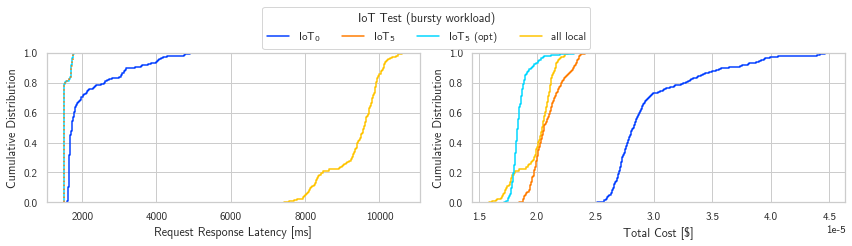

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["IoT$_0$", 'IoT$_5$', 'IoT$_5$ (opt)', 'all local']

sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

#ax1.lines[1].set_linestyle("--")
ax1.lines[2].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, ncol=5, loc="upper center", title="IoT Test (bursty workload)", bbox_to_anchor=(0, 0.66, 1, 0.5))
save_fig(fig, "iot/bursty")

In [50]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 3184.063400576369, Confidence Interval: (3023.6487918964876 / 3344.4780092562505), Median: 1648.0 for rootDuration
Mean: 8809.773775216137, Confidence Interval: (8571.706684574412 / 9047.840865857863), Median: 9633.0 for billedDuration
Mean: 2.2509799486367724e-05, Confidence Interval: (2.223927957910562e-05 / 2.278031939362983e-05), Median: 2.05803078272e-05 for totalCost
------ a_remote
 minmem: [128]
Mean: 2122.976, Confidence Interval: (2042.3457461577566 / 2203.606253842244), Median: 1720.0 for rootDuration
Mean: 13982.872, Confidence Interval: (13785.457934182963 / 14180.286065817036), Median: 13246.0 for billedDuration
Mean: 2.9830186593587208e-05, Confidence Interval: (2.9409035744210847e-05 / 3.0251337442963568e-05), Median: 2.82581898496e-05 for totalCost
------ b_local
 minmem: [128]
Mean: 9369.285171102661, Confidence Interval: (9282.61049312722 / 9455.959849078103), Median: 9581.0 for rootDuration
Mean: 9373.866920152092, Confidence Interval: (9287.416

# Webshop Normal

In [51]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/webshop/generateConfigurations/statistics/fixedcheckout-m-4-x-111-x-3")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "1676376424": "Shop$_0$",
    "1676376883": "Shop$_1$",
    "1676378281": "Shop$_2$",
    "1676383779": "Shop$_3$",
    "1676385324": "Shop$_4$",
    "1676388535": "Shop$_5$",
    "1676387708": "Shop$_6$",
    "1676389085": "Shop$_7$",
    "1676383303": "Shop$_8$",
    "1676378737": "Shop$_9$",
    "1676390159": "Shop$_10$",
    "1676389591": "Shop$_8$ (A MB)",
    "1676379194": "Shop$_8$ (B MB)",
    "1676379640": "Shop$_8$ (C MB)", ## now addcartitem-1650
    "1676377347": "Shop$_8$ (opt)", ## -128
    "1676377830": "Shop$_5$",
    "1676375682": "Shop$_6$"
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

# Only show the initial 3 and optimal fusion group
cond = (grouped['fusionGroup', 'min'] <= 1676302444) | (grouped['fusionGroup', 'min'] == 1676305238)
grouped_filtered = grouped[cond]

cond = (df['fusionGroup'] <= 1676302444) | (df['fusionGroup'] == 1676305238)
df_filtered = df[cond]

/tmp/ipykernel_87177/3995013971.py:62: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


/tmp/ipykernel_87177/3345720587.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors)
/tmp/ipykernel_87177/3345720587.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)
TeX  NOT subset; don't know how to subset; dropped


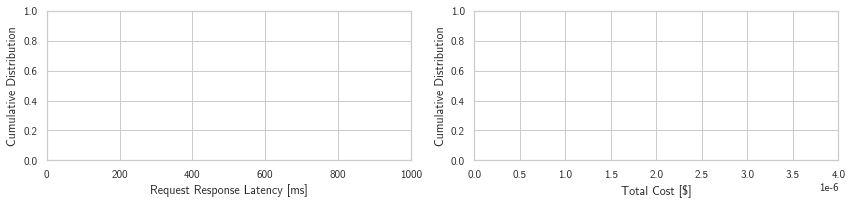

In [52]:
colors = sns.color_palette("bright", 18)#[iot0, iot1, iot2, iot3, iot4, iot5, iot5o]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.set_xlim(0, 1000)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
ax2.set_xlim(0.0000, 0.000004)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors)
sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)

#ax1.lines[0].set_linestyle("--")
#ax1.lines[1].set_linestyle(":")
labels=["Shop$_0$","Shop$_1$","Shop$_2$","Shop$_3$","Shop$_4$","Shop$_5$","Shop$_6$","Shop$_7$","Shop$_8$","Shop$_8$ (opt)",]

#fig.legend(handles=reversed(ax2.get_lines()), labels=labels, ncol=10, loc="upper center", title="Webshop Test", bbox_to_anchor=(0, 0.7, 1, 0.5))
save_fig(fig, "webshop/allNormal")

In [53]:
printStats(grouped_filtered, fusion_groups_order)

------ overall
Mean: nan, Confidence Interval: (nan / nan), Median: nan for rootDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for billedDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for totalCost
------ 1676375682
 minmem: []
Mean: nan, Confidence Interval: (nan / nan), Median: nan for rootDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for billedDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for totalCost
------ 1676376424
 minmem: []
Mean: nan, Confidence Interval: (nan / nan), Median: nan for rootDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for billedDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for totalCost
------ 1676376883
 minmem: []
Mean: nan, Confidence Interval: (nan / nan), Median: nan for rootDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for billedDuration
Mean: nan, Confidence Interval: (nan / nan), Median: nan for totalCost
------ 1676